In [1]:
import gym
import pdb
from time import sleep
import pdb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from scipy import misc
from skimage import color
from collections import deque
import random
%matplotlib inline
print "Done"

/Users/thalles/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Done


In [2]:
PIXEL_DEPTH=255.
IMAGE_SIZE=84
def process_input(img):
    out = img[:171, :] # get only the playing area of the image
    out = misc.imresize(out, (IMAGE_SIZE,IMAGE_SIZE))
    r, g, b = out[:,:,0], out[:,:,1], out[:,:,2]
    out = r * (299./1000.) + r * (587./1000.) + b * (114./1000.)
    out = (out - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    
    return out

In [3]:
GAME_NAME="MsPacman-v0"

[2016-10-03 17:26:07,598] Making new env: MsPacman-v0


Image origial shape: (210, 160, 3)
New image shape: (84, 84)


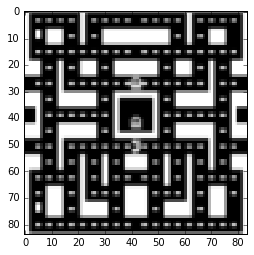

In [4]:
env = gym.make(GAME_NAME)
env.reset()

img = env.render('rgb_array')
print "Image origial shape:", img.shape
# plt.imshow(img, cmap='gray', interpolation='nearest')

out = process_input(img)
print "New image shape:", out.shape
plt.imshow(out.squeeze(), cmap='gray', interpolation='nearest')

In [5]:
NUM_ACTIONS = env.action_space.n
NUM_FRAMES_PER_STATE=4

In [6]:
SEED = 999

def weight_variable(name, shape):
  return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer(seed=SEED))

def weight_conv_variable(name, shape):
  return tf.get_variable(name=name, shape=shape, 
                         initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=SEED))

def bias_variable(shape):
  initial = tf.zeros_initializer(shape=shape, dtype=tf.float32)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x, strides=[1, 2, 2, 1]):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=strides, padding='SAME')

In [7]:
CONV1_DEPTH=16
W_conv1 = weight_conv_variable("conv1", [5, 5, NUM_FRAMES_PER_STATE, CONV1_DEPTH])
b_conv1 = bias_variable([CONV1_DEPTH])

CONV2_DEPTH=32
W_conv2 = weight_conv_variable("conv2", [5, 5, CONV1_DEPTH, CONV2_DEPTH])
b_conv2 = bias_variable([CONV2_DEPTH])

FC1_SIZE = 255
W_fc1 = weight_variable("fc1", [21 * 21 * CONV2_DEPTH, FC1_SIZE])
b_fc1 = bias_variable([FC1_SIZE])

out_layer = weight_variable("out1", [FC1_SIZE, NUM_ACTIONS])
bias_layer = bias_variable([NUM_ACTIONS])

In [12]:
class LearningAgent:
    def __init__(self, env):
        # game variables and constants
        self._env = env
        self.state = None
        self.ACTION_NAMES = self._env.get_action_meanings()
        self.NUM_ACTIONS = env.action_space.n
        self.action = 0 # default first action
        
        # AI variables and constants
        self.REPLAY_MEN = 10000 # The paper remember the 1000000 most recent frames
        self.exp_replay_list = deque(maxlen=self.REPLAY_MEN)
        self.SKIP_FRAME_RATE = 4
        self.NUM_FRAMES_PER_STATE = 4
        self.OBSERVATION_STEPS = 500
        
        # Q LEARNING variables and constants
        self.STARTER_EPSILON = 1.0
        self.learning_rate = 1e-5
        self.discount_factor = 0.9
        self.MINI_BATCH_SIZE = 32
        
        # Tensorflow variables
        self.SEED = 999
        self._session = tf.Session() 
        self._input = tf.placeholder(tf.float32, shape=(None,) + (IMAGE_SIZE,IMAGE_SIZE,self.NUM_FRAMES_PER_STATE), name="input_images")
        self._target = tf.placeholder(tf.float32, [None], name="input_targets")
        self._action = tf.placeholder(tf.float32, [None, self.NUM_ACTIONS], name="input_actions")
        
        # Create Deep model
        self.model_output = self.model(self._input)
        
        self.train_step()
        
        self._session.run(tf.initialize_all_variables())

    def train_step(self):
        # train variables
        readout_action = tf.reduce_sum(tf.mul(self.model_output, self._action), reduction_indices=1)
        self.loss_operation = tf.reduce_mean(tf.square(self._target - readout_action))
        self._train_operation = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss_operation)
        
    def model(self, inputs, training=True):        
        h_conv1 = tf.nn.relu(conv2d(inputs, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)

        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

        shape = h_pool2.get_shape().as_list()
        h_pool_flat = tf.reshape(h_pool2, [-1, shape[1] * shape[2] * shape[3]])
        
        # First fully connected layer
        h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
        if (training == True):
            h_fc1 = tf.nn.dropout(h_fc1, 0.92, seed=self.SEED)
        
        q_actions = tf.matmul(h_fc1, out_layer) + bias_layer
        
#         with slim.arg_scope([slim.conv2d, slim.max_pool2d],
#                       padding="SAME"):

#             with slim.arg_scope([slim.conv2d, slim.fully_connected],
#                       activation_fn=tf.nn.relu,
#                       weights_regularizer=slim.l2_regularizer(0.0005)):

#                 net = slim.conv2d(inputs, num_outputs=16, kernel_size=[5,5])
#                 net = slim.max_pool2d(net, [2, 2], stride=2)

#                 net = slim.conv2d(net, num_outputs=32, kernel_size=[5,5])
#                 net = slim.max_pool2d(net, [2, 2], stride=2)

#                 net = slim.flatten(net)

#                 fc = slim.fully_connected(net, 256)
#                 fc = slim.dropout(fc, 0.5)

#                 out = slim.fully_connected(fc, self.NUM_ACTIONS, activation_fn=None)

        return q_actions
    
    
    def to_one_hot_vec(self, actions):
        one_hot = np.zeros((self.MINI_BATCH_SIZE, self.NUM_ACTIONS))
        one_hot[np.arange(self.MINI_BATCH_SIZE), actions] = 1
        return one_hot

    def train(self):
        # Sample random minibatch of transitions (s_i, a_i, r_i, s_i+1)
        # from the experience replay list
        mini_batch = random.sample(self.exp_replay_list, self.MINI_BATCH_SIZE)
        previous_states = [d[0] for d in mini_batch]
        actions = [d[1] for d in mini_batch]
        rewards = [d[2] for d in mini_batch]
        current_states = [d[3] for d in mini_batch]
        
        agents_expected_reward = []
        # this gives us the agents expected reward for each action we might take
        agents_reward_per_action = self._session.run(self.model_output, feed_dict={self._input: current_states})
        
        for i in range(len(mini_batch)):
            if mini_batch[i][4]:
                # this was a terminal frame so there is no future reward...
                agents_expected_reward.append(rewards[i])
            else:
                # compute r_j + γ max Q(s_j, a; θ), 
                #    where:
                #      s_j is the current state
                #      θ are the CNNs learned weights
                agents_expected_reward.append(
                    rewards[i] + self.discount_factor * np.max(agents_reward_per_action[i]))

        # Perform a gradient descent step on (y_j − Q(φ_j, a_j; θ))^2
        _, loss = self._session.run([self._train_operation, self.loss_operation], feed_dict={
            self._input: previous_states,
            self._action: self.to_one_hot_vec(actions),
            self._target: agents_expected_reward})
        
        return loss
        
    def reset_env(self):
        return self._env.reset()

    def get_random_action(self):
        return self._env.action_space.sample()

    def get_action_name(self, action):
        return self.ACTION_NAMES[action]
    
    # for the first step, the state is the same state repeated [STATE_FRAMES] times
    def game_initial_setup(self):
        observations = process_input(self.reset_env())
        self.state = np.stack(tuple(observations for _ in range(self.NUM_FRAMES_PER_STATE)), axis=2)
        print "First state:", self.state.shape
    
    def get_next_action(self, step):
        out = self.action
        # With probability p select a random action (a) otherwise select a = maxaQ∗(φ(st), a; θ)
        
        p = self.linear_decay(step, decay_step=0.00001)
        
        if step % self.SKIP_FRAME_RATE == 0:
            print "Epsilon:", p
            if random.random() < p:
                out = self.get_random_action()
                # print "Step id:", step, "Random Action: ", self.action, ":", self.get_action_name(self.action)
            else:
                current_state = np.expand_dims(self.state, axis=0)
                q_action = self._session.run(self.model_output, feed_dict={self._input: current_state})
                out = np.argmax(q_action)
                # print "Step id:", step, "Q Action: ", self.action, ":", self.get_action_name(self.action)
        return out
    
    # perform an exponential decay method
    # the paper recommends a decay_step of 0.0000009
    def linear_decay(self, global_step, decay_step):
        out = self.STARTER_EPSILON - (decay_step * (global_step + 1.0))
        out if (out > 0.1) else 0.1
        return out
    
    def update(self, step):
        
        self._env.render()

        self.action = self.get_next_action(step)

        # Execute action a_t in emulator and observe reward r_t and image x_t+1
        new_observation, reward, done, info = self._env.step(self.action)
        
        if step % self.SKIP_FRAME_RATE == 0:
            # Set s_t+1 = s_t, a_t, x_t+1 and preprocess s_t+1 = φ(st+1)
            new_observation = process_input(new_observation)
            new_observation = np.expand_dims(new_observation, axis=2)

            # tore transition (φ_t, a_t, r_t, φ_t+1) in D (experience decay collection)
            next_state = np.append(self.state[:, :, 1:], new_observation, axis=2)
            self.exp_replay_list.append([self.state, self.action, reward, next_state, done])

            self.state = next_state

            # only train if done observing
            if len(self.exp_replay_list) > self.OBSERVATION_STEPS:
                loss = self.train()
                print "Step: ", step, "Action:", self.get_action_name(self.action), "Loss:", loss
        
        # pdb.set_trace()

        if done:
            self.reset_env()
            print("Episode finished after {} timesteps".format(t+1))
            return

In [13]:
agent = LearningAgent(env)
agent.game_initial_setup()

DELAY = 0.05
EPSODE_SIZE = 100000

for t in range(EPSODE_SIZE):
    step = t

    agent.update(step)

    sleep(DELAY)

First state: (84, 84, 4)
Epsilon: 0.99999
Epsilon: 0.99995
Epsilon: 0.99991
Epsilon: 0.99987
Epsilon: 0.99983
Epsilon: 0.99979
Epsilon: 0.99975
Epsilon: 0.99971
Epsilon: 0.99967
Epsilon: 0.99963
Epsilon: 0.99959
Epsilon: 0.99955
Epsilon: 0.99951
Epsilon: 0.99947
Epsilon: 0.99943
Epsilon: 0.99939
Epsilon: 0.99935
Epsilon: 0.99931
Epsilon: 0.99927
Epsilon: 0.99923
Epsilon: 0.99919
Epsilon: 0.99915
Epsilon: 0.99911
Epsilon: 0.99907
Epsilon: 0.99903
Epsilon: 0.99899
Epsilon: 0.99895
Epsilon: 0.99891
Epsilon: 0.99887
Epsilon: 0.99883
Epsilon: 0.99879
Epsilon: 0.99875
Epsilon: 0.99871
Epsilon: 0.99867
Epsilon: 0.99863
Epsilon: 0.99859
Epsilon: 0.99855
Epsilon: 0.99851
Epsilon: 0.99847
Epsilon: 0.99843
Epsilon: 0.99839
Epsilon: 0.99835
Epsilon: 0.99831
Epsilon: 0.99827
Epsilon: 0.99823
Epsilon: 0.99819
Epsilon: 0.99815
Epsilon: 0.99811
Epsilon: 0.99807
Epsilon: 0.99803
Epsilon: 0.99799
Epsilon: 0.99795
Epsilon: 0.99791
Epsilon: 0.99787
Epsilon: 0.99783
Epsilon: 0.99779
Epsilon: 0.99775
Epsilo

KeyboardInterrupt: 

In [ ]:
img = agent.exp_replay_list[0][3]
print img.shape
#print agent.state[:, :, 1].shape
plt.imshow(img[:,:,3], cmap='gray', interpolation='nearest')